In [42]:
import os, re, glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
batch_size = 32
BASE_DIR = f"../../synthetic_results_{batch_size}"
METHODS = [
    "qpth",
    "ffoqp_eq_schur",
    "ffocp_eq"
]

def load_results(base_dir=BASE_DIR, methods=METHODS):
    dfs = []
    for m in methods:
        pattern = os.path.join(base_dir, m, "*.csv")
        for fp in sorted(glob.glob(pattern)):
            df = pd.read_csv(fp)
            df["method"] = m

            fname = os.path.basename(fp)
            def grab(pat, cast=float):
                mo = re.search(pat, fname)
                return cast(mo.group(1)) if mo else np.nan

            df["seed"] = grab(r"_seed(\d+)", int)
            df["ydim"] = grab(r"ydim(\d+)", int)
            df["lr"]   = grab(r"lr([0-9eE\.\-]+)", float)
            # df["eps"]  = grab(r"eps([0-9eE\.\-]+)", float)

            dfs.append(df)

    if not dfs:
        raise FileNotFoundError(f"No CSVs found under {base_dir}.")
    return pd.concat(dfs, ignore_index=True, sort=False)

df = load_results()

# for c in ["epoch","test_ts_loss","test_df_loss","forward_time","backward_time"]:
#     if c not in df.columns:
#         df[c] = np.nan

In [44]:
df

,epoch,train_ts_loss,test_ts_loss,train_df_loss,test_df_loss,forward_time,backward_time,method,seed,ydim,lr
0,0,0.519425,0.489860,-0.012826,-0.012388,14.482871,1.752115,qpth,3,200,0.00001
1,1,0.506742,0.497832,-0.015227,-0.016550,13.705173,1.751442,qpth,3,200,0.00001
2,2,0.486114,0.474490,-0.019403,-0.023621,14.178361,1.567524,qpth,3,200,0.00001
3,3,0.451187,0.430654,-0.031970,-0.042636,14.768821,1.664224,qpth,3,200,0.00001
4,4,0.412340,0.394611,-0.053640,-0.063720,13.677834,1.485104,qpth,3,200,0.00001
5,5,0.380077,0.369367,-0.074611,-0.083753,13.636364,1.585371,qpth,3,200,0.00001
6,6,0.355409,0.344488,-0.093751,-0.100320,13.254179,1.677306,qpth,3,200,0.00001
7,7,0.334863,0.327472,-0.111296,-0.117416,13.328660,1.626051,qpth,3,200,0.00001
8,8,0.317594,0.309849,-0.128329,-0.132879,15.490176,1.778829,qpth,3,200,0.00001
9,9,0.302998,0.301452,-0.145111,-0.151537,18.005075,1.830356,qpth,3,200,0.00001


/nethome/sho73/miniconda3/envs/bilevel/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/nethome/sho73/miniconda3/envs/bilevel/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


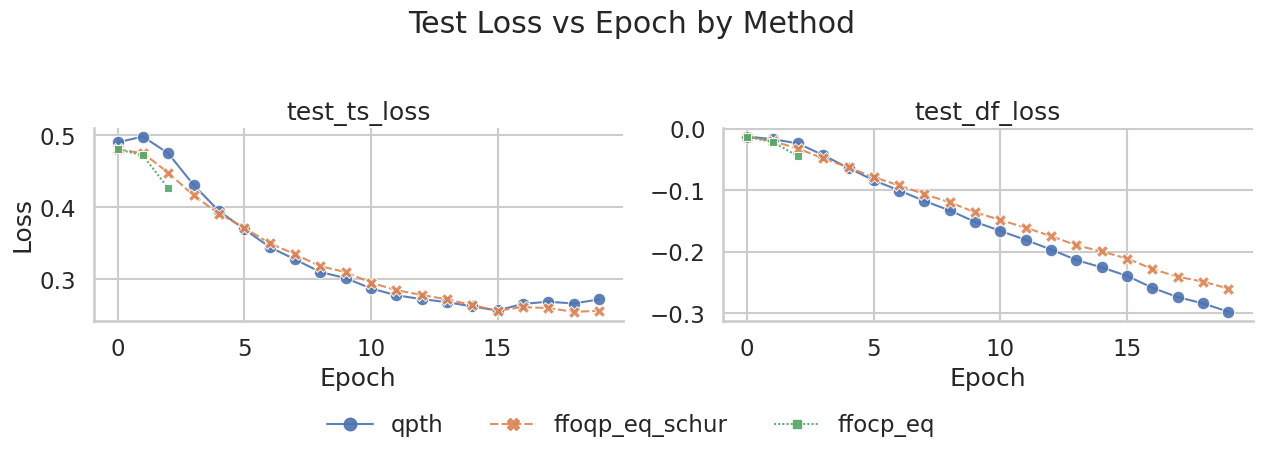

In [45]:
import matplotlib.patheffects as pe

sns.set_theme(style="whitegrid", context="talk")

df = df.rename(columns=lambda c: c.strip() if isinstance(c, str) else c)

metric_cols = [c for c in ["test_ts_loss", "test_df_loss"] if c in df.columns]
id_vars = [c for c in ["epoch","method","seed","ydim"] if c in df.columns]

long_curves = df.melt(
    id_vars=id_vars,
    value_vars=metric_cols,
    var_name="metric", value_name="value"
).dropna(subset=["value","epoch","method"])

g = sns.relplot(
    data=long_curves, x="epoch", y="value",
    hue="method", style="method",
    markers=True, dashes=True,
    kind="line", ci=None,
    linewidth=1.5, alpha=0.9,
    col="metric", col_wrap=2, height=4, aspect=1.3,
    facet_kws=dict(sharey=False)
)

g.set_titles("{col_name}")
g.set_xlabels("Epoch"); g.set_ylabels("Loss")
plt.suptitle("Test Loss vs Epoch by Method", y=1.02)


handles, labels = g.axes.flat[0].get_legend_handles_labels()
if g._legend is not None:
    g._legend.remove()

seen = set()
hl = [(h, l) for h, l in zip(handles, labels) if not (l in seen or seen.add(l))]

if hl and hl[0][1].lower() == "method":
    hl = hl[1:]
handles, labels = zip(*hl) if hl else ([], [])

g.fig.legend(
    handles, labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=max(1, len(labels)),
    frameon=False
)
g.fig.subplots_adjust(bottom=0.50)

plt.tight_layout()
plt.show()



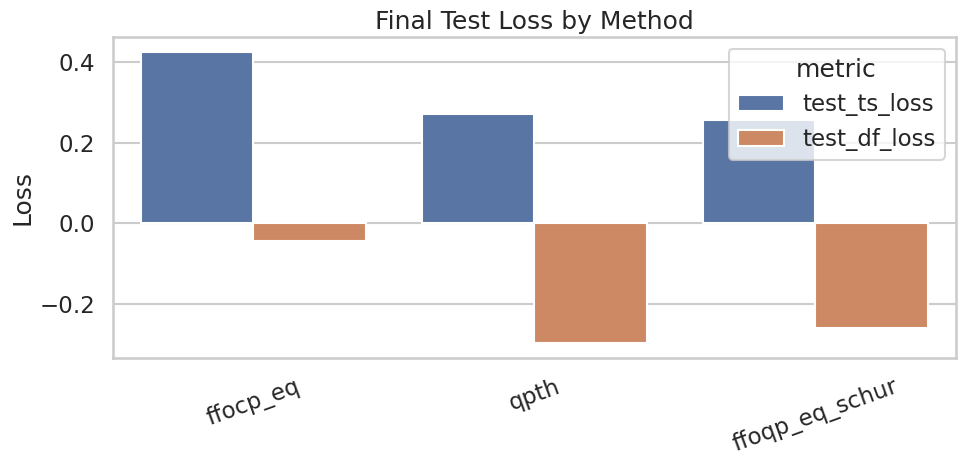

In [46]:
keys = ["method","seed"] if "seed" in df.columns else ["method"]

if "epoch" in df.columns and df["epoch"].notna().any():
    last_rows = df.sort_values("epoch").groupby(keys, dropna=False).tail(1)
else:
    last_rows = df.groupby(keys, dropna=False).tail(1)

time_median = (
    df.groupby(keys, dropna=False)[["forward_time","backward_time"]]
      .median().reset_index()
)

final = last_rows.merge(
    time_median, on=keys, how="left",
    suffixes=("", "_median")
)

loss_final = final.melt(
    id_vars=["method","seed","ydim"],
    value_vars=["test_ts_loss","test_df_loss"],
    var_name="metric", value_name="value"
).dropna(subset=["value","method"])

plt.figure(figsize=(10,5))
ax = sns.barplot(data=loss_final, x="method", y="value", hue="metric", errorbar=("ci",95))
ax.set_title("Final Test Loss by Method")
ax.set_xlabel(""); ax.set_ylabel("Loss")
ax.tick_params(axis="x", rotation=20)
plt.tight_layout()
# plt.savefig("final_losses_by_method.png", dpi=200)

/tmp/ipykernel_777170/3810251276.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_method = (data.groupby("method", as_index=False)["value"].mean()
/tmp/ipykernel_777170/3810251276.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_method = (data.groupby("method", as_index=False)["value"].mean()


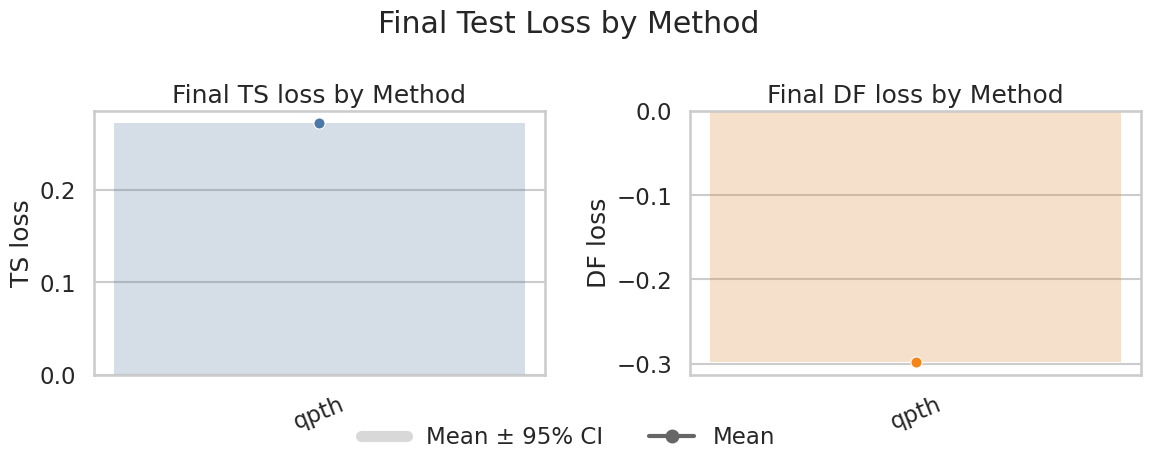

In [47]:
keys = ["method","seed"] if "seed" in df.columns else ["method"]

if "epoch" in df.columns and df["epoch"].notna().any():
    last_rows = df.sort_values("epoch").groupby(keys, dropna=False).tail(1)
else:
    last_rows = df.groupby(keys, dropna=False).tail(1)

time_median = (
    df.groupby(keys, dropna=False)[["forward_time","backward_time"]]
      .median().reset_index()
)

final = last_rows.merge(
    time_median, on=keys, how="left",
    suffixes=("", "_median")
)

loss_final = final.melt(
    id_vars=["method","seed","ydim"],
    value_vars=["test_ts_loss","test_df_loss"],
    var_name="metric", value_name="value"
).dropna(subset=["value","method"])
 
import pandas as pd
from matplotlib.lines import Line2D

method_order_all = [
    "cvxpylayer","qpth","ffoqp",
    "ffoqp_eq_cst","ffoqp_eq_cst_pdipm",
    "ffoqp_eq_cst_parallelize","ffoqp_eq_cst_schur"
]
method_order = [m for m in method_order_all if m in loss_final["method"].unique()]

name_map = {"test_ts_loss": "TS loss", "test_df_loss": "DF loss"}

fig, axes = plt.subplots(1, 2, figsize=(12, 4.6), sharey=False)
metrics = ["test_ts_loss", "test_df_loss"]
colors  = ["#4c78a8", "#f58518"]

for ax, met, c in zip(axes, metrics, colors):
    data = loss_final[loss_final["metric"] == met].copy()
    data["method"] = pd.Categorical(data["method"], categories=method_order, ordered=True)

    sns.barplot(
        data=data, x="method", y="value",
        order=method_order, ax=ax,
        color=c, alpha=0.25, edgecolor="none",
        errorbar=("ci", 95), capsize=0.1
    )

    mean_by_method = (data.groupby("method", as_index=False)["value"].mean()
                          .sort_values("method"))
    sns.lineplot(
        data=mean_by_method, x="method", y="value",
        marker="o", linewidth=3.0, markersize=8, color=c,
        ax=ax, zorder=3, legend=False
    )

    ax.set_title(f"Final {name_map[met]} by Method")
    ax.set_xlabel(""); ax.set_ylabel(name_map[met])
    ax.tick_params(axis="x", rotation=22)

fig.suptitle("Final Test Loss by Method", y=0.98)
handles = [
    Line2D([0],[0], color="#666", lw=8, alpha=0.25, label="Mean ± 95% CI"),
    Line2D([0],[0], color="#666", lw=3.0, marker="o", label="Mean")
]
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.02),
           ncol=2, frameon=False)

fig.subplots_adjust(bottom=0.18, wspace=0.25)
plt.tight_layout()
plt.show()


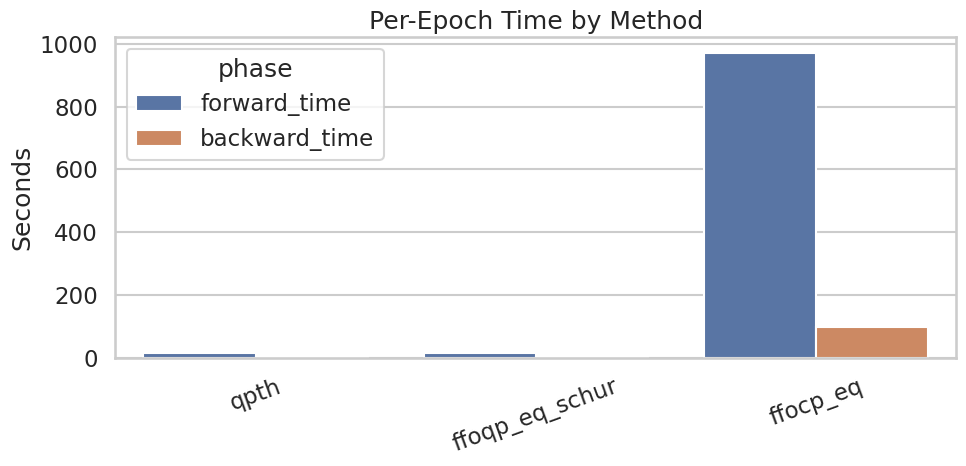

In [48]:
time_long = time_median.melt(id_vars=["method","seed"], value_vars=["forward_time","backward_time"],
                             var_name="phase", value_name="seconds").dropna(subset=["seconds","method"])

# method_order_all = [
#     "cvxpylayer","qpth","ffoqp",
#     "ffoqp_eq_cst","ffoqp_eq_cst_pdipm",
#     "ffoqp_eq_cst_parallelize","ffoqp_eq_cst_schur"
# ]
method_order_all = METHODS
method_order = [m for m in method_order_all if m in time_long["method"].unique()]
phase_order = ["forward_time", "backward_time"]
time_long["method"] = pd.Categorical(time_long["method"],
                                     categories=method_order, ordered=True)

plt.figure(figsize=(10,5))
ax = sns.barplot(
    data=time_long,
    x="method", y="seconds",
    hue="phase",
    order=method_order,
    hue_order=phase_order,
    errorbar=("ci",95)
)
ax.set_title("Per-Epoch Time by Method")
ax.set_xlabel(""); ax.set_ylabel("Seconds")
ax.tick_params(axis="x", rotation=20)
plt.tight_layout()
# plt.savefig("median_time_by_method.png", dpi=200)